# <font color=Green> **DATASET ANALYSIS**</font>

In this document, it recorded the codes that provided the analysis for the full technical report on the Airline Passanger Satisfaction. Dataset is from Kaggle: https://www.kaggle.com/datasets/johndddddd/customer-satisfaction


1. Import necessary packages and necessary classes for analysis
2. Import 'satisfaction_2015.xlsx' as dataset and cleaning the data, including: 
- Check NULL values
- Rename columns
- Rename variables within columns
- Check Correlation Matrix
3. Setting Working Dataset and Holdout Dataset
4. EDA on all columns
5. Descriptive Analysis on the 14 service touchpoints
6. Importance Weightage
*   Logistic Regression (all columns vs 14 service touchpoints) 
*   Random Forest (all columns vs 14 service touchpoints) 
*   XGBoost (all columns vs 14 service touchpoints)
7. Holdout Data comparison.


## <font color=orange> 1. Import necessary packages and necessary classes for analysis </font> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import zipfile
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chisquare as chsq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier

## <font color=orange> 2. Import 'satisfaction_2015.xlsx' as dataset and cleaning the data </font>

In [2]:
cx_sat = pd.read_csv('./datasets/satisfaction_2015.csv')

In [3]:
cx_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129880 non-null  int64  
 1   satisfaction_v2                    129880 non-null  object 
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      1298

#### <font color=orange> DATA CLEANING </font>

Noticed that there are missing values in 'Arrival Delay in Minutes'. For this analysis purpose, we will be replacing them with 0 because:
1. We noticed that the sample size for null value is significantly small compared to the OG dataset.
2. This column will be ignored for this predictive model based on the correlation matrix done during EDA.

In [4]:
null_count = cx_sat['Arrival Delay in Minutes'].isnull().sum()
zero_count = (cx_sat['Arrival Delay in Minutes'] == 0).sum()

print(f"Number of null values in 'Arrival Delay in Minutes': {null_count}")
print(f"Number of zero values in 'Arrival Delay in Minutes': {zero_count}")

Number of null values in 'Arrival Delay in Minutes': 393
Number of zero values in 'Arrival Delay in Minutes': 72753


In [5]:
cx_sat['Arrival Delay in Minutes'] = cx_sat['Arrival Delay in Minutes'].fillna(0)

In [6]:
cx_sat['Arrival Delay in Minutes'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 129880 entries, 0 to 129879
Series name: Arrival Delay in Minutes
Non-Null Count   Dtype  
--------------   -----  
129880 non-null  float64
dtypes: float64(1)
memory usage: 1014.8 KB


#### **Removing ID Column**

Noticed that column 'id' is survey id, which is not meaningful for the purpose of predicting a customer satisfaction rate and customer's loyalty.

Hence, the column is removed

In [7]:
cx_sat = cx_sat.drop(columns=['id'])

In [8]:
cx_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction_v2                    129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Ease of Online booking             129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     1298

#### **Renaming Column(s)**

Noticed that all of the columns are well renamed.

'satisfaction_v2' -> 'satisfaction_result' <br>
'Online boarding' -> 'Online Checkin'

In [9]:
cx_sat = cx_sat.rename(columns={'satisfaction_v2': 'satisfaction_result',
                                'Ease of Online booking': 'Online Booking',
                                'Online boarding': 'Online Check-in'})

In [10]:
cx_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction_result                129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Online Booking                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     1298

In [11]:
cx_sat = cx_sat.rename(columns={'satisfaction_v2': 'satisfaction_result'})

#### **Renaming Ouput(s)**

In [12]:
cx_sat['Customer Type'].value_counts()

Customer Type
Loyal Customer       106100
disloyal Customer     23780
Name: count, dtype: int64

In [13]:
# Change the input for Loyal Customer -> Frequent Flyer & Disloyal Customer -> Infrequent Flyer
cx_sat['Customer Type'].replace({'Loyal Customer': 'Frequent Flyer', 'disloyal Customer': 'Infrequent Flyer'}, inplace=True)

In [14]:
cx_sat['Customer Type'].unique()

array(['Infrequent Flyer', 'Frequent Flyer'], dtype=object)

In [15]:
#to check the number of counts before and after the change are the same
cx_sat['Customer Type'].value_counts()

Customer Type
Frequent Flyer      106100
Infrequent Flyer     23780
Name: count, dtype: int64

In [16]:
cx_sat.head(8)

,satisfaction_result,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Online Booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Male,Infrequent Flyer,56,Personal Travel,Eco,369,0,2,0,...,3,3,1,5,3,3,4,3,0,0.0
1,satisfied,Male,Infrequent Flyer,49,Personal Travel,Eco,2486,0,2,1,...,3,2,1,1,4,4,3,2,0,0.0
2,satisfied,Male,Infrequent Flyer,55,Personal Travel,Eco,1448,0,3,0,...,3,3,3,5,3,2,3,3,0,0.0
3,satisfied,Female,Infrequent Flyer,36,Personal Travel,Eco,1501,0,4,0,...,4,4,5,4,5,5,5,4,0,0.0
4,satisfied,Male,Infrequent Flyer,55,Personal Travel,Eco,577,0,5,0,...,3,3,3,4,5,3,4,3,0,0.0
5,neutral or dissatisfied,Female,Infrequent Flyer,15,Personal Travel,Eco,2704,1,0,1,...,1,1,5,3,5,5,5,1,0,0.0
6,neutral or dissatisfied,Male,Infrequent Flyer,51,Personal Travel,Eco,1746,1,0,1,...,1,1,5,3,5,4,4,1,20,22.0
7,neutral or dissatisfied,Female,Infrequent Flyer,26,Personal Travel,Eco,650,1,1,1,...,2,2,2,5,2,1,3,2,0,0.0


#### <font color=Yellow> **Correlation Matrix**</font>

This is to see if there are any variables that are dependent on another varaible, where we can remove the possible varaible for less noise.

In [17]:
# Select only numerical columns for correlation calculation
numerical_col = cx_sat.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_col.corr()

# Display the correlation matrix
display(correlation_matrix)

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Online Booking,Gate location,Food and drink,Online Check-in,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
Age,1.000000,0.099459,0.016116,0.036960,0.022565,-0.000398,0.023194,0.207572,0.159136,0.074947,0.057078,0.039119,-0.047991,0.033475,-0.051347,0.052565,-0.009041,-0.011206
Flight Distance,0.099459,1.000000,0.006701,-0.018914,0.065165,0.005520,0.057066,0.214825,0.157662,0.130507,0.111194,0.134533,0.064855,0.073608,0.059316,0.095648,0.002402,-0.001973
Inflight wifi service,0.016116,0.006701,1.000000,0.344915,0.714807,0.338573,0.132214,0.457445,0.121513,0.207802,0.119928,0.160317,0.120376,0.043762,0.110029,0.131300,-0.015946,-0.017762
Departure/Arrival time convenient,0.036960,-0.018914,0.344915,1.000000,0.437620,0.447510,0.000687,0.072287,0.008666,-0.008380,0.067297,0.010617,0.070833,0.091132,0.072195,0.009862,0.000778,-0.001005
Online Booking,0.022565,0.065165,0.714807,0.437620,1.000000,0.460041,0.030514,0.404866,0.028561,0.046564,0.039064,0.109450,0.039148,0.008819,0.035373,0.015125,-0.005318,-0.007046
Gate location,-0.000398,0.005520,0.338573,0.447510,0.460041,1.000000,-0.002872,0.002756,0.002788,0.002741,-0.029019,-0.005181,0.000972,-0.039353,0.000310,-0.005918,0.005973,0.005643
Food and drink,0.023194,0.057066,0.132214,0.000687,0.030514,-0.002872,1.000000,0.233500,0.575846,0.623461,0.057404,0.033173,0.035321,0.085198,0.035210,0.658054,-0.029164,-0.031685
Online Check-in,0.207572,0.214825,0.457445,0.072287,0.404866,0.002756,0.233500,1.000000,0.419253,0.283922,0.154242,0.123225,0.083541,0.204238,0.074058,0.329377,-0.019404,-0.022663
Seat comfort,0.159136,0.157662,0.121513,0.008666,0.028561,0.002788,0.575846,0.419253,1.000000,0.611837,0.130545,0.104272,0.074620,0.189979,0.068842,0.679613,-0.027999,-0.030397
Inflight entertainment,0.074947,0.130507,0.207802,-0.008380,0.046564,0.002741,0.623461,0.283922,0.611837,1.000000,0.418574,0.300397,0.379123,0.119554,0.406094,0.692511,-0.027012,-0.030183


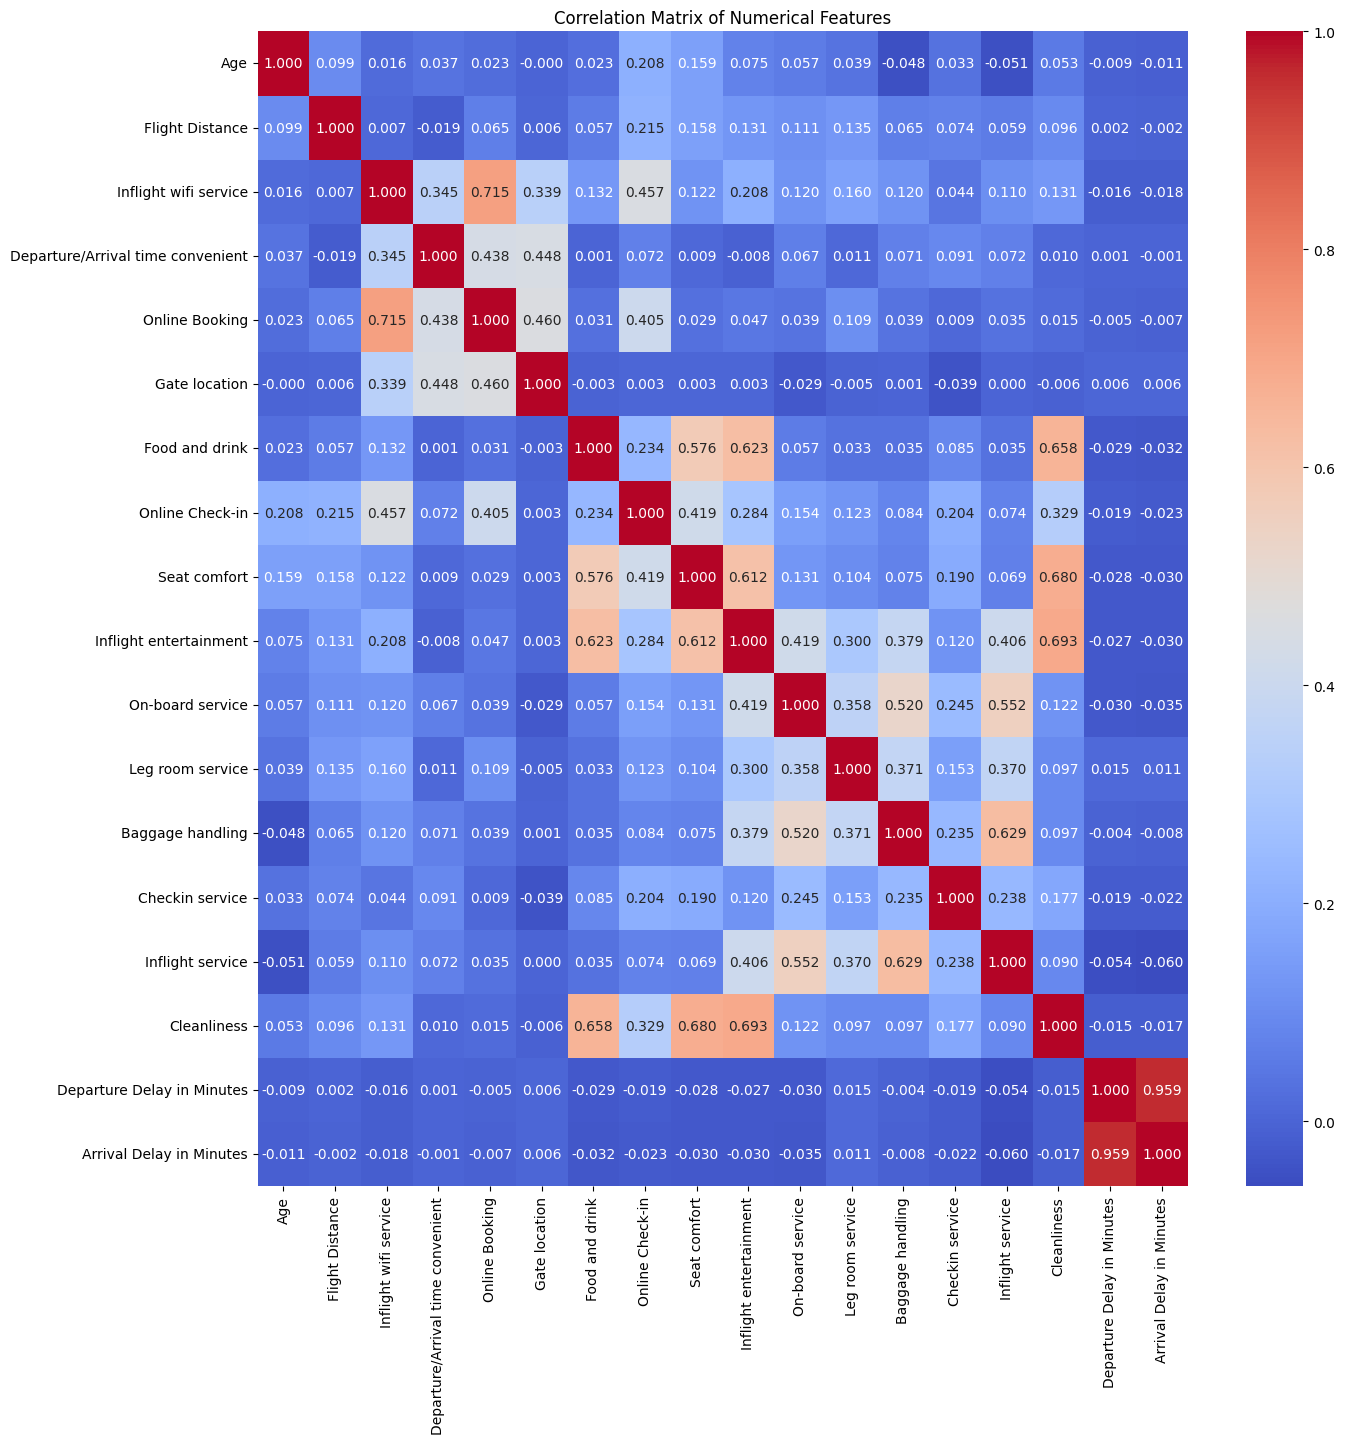

In [18]:
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Noticed that Arrival Delay in Minutes is strongly correlated with Departure Delay in minutes, where lateness in departure tends to lead to lateness in Arrival at the arriving airport. <br>

Hence, we will be removing Arrical Delay in Minutes from the dataset

In [19]:
cx_sat = cx_sat.drop(columns=['Arrival Delay in Minutes'])

## **<font color = orange> 3. Working Data vs Holdout Data </font>**

3% of the dataset will be stratified out from the original dataset with equal number of ‘satisfied’ and ‘'neutral or dissatisfied' customer, and labelled as Holdout Data.  

In [20]:
HO_set = cx_sat.groupby('satisfaction_result', group_keys=False).apply(lambda x: x.sample(frac=0.05))

In [21]:
HO_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6494 entries, 1023 to 98084
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   satisfaction_result                6494 non-null   object
 1   Gender                             6494 non-null   object
 2   Customer Type                      6494 non-null   object
 3   Age                                6494 non-null   int64 
 4   Type of Travel                     6494 non-null   object
 5   Class                              6494 non-null   object
 6   Flight Distance                    6494 non-null   int64 
 7   Inflight wifi service              6494 non-null   int64 
 8   Departure/Arrival time convenient  6494 non-null   int64 
 9   Online Booking                     6494 non-null   int64 
 10  Gate location                      6494 non-null   int64 
 11  Food and drink                     6494 non-null   int64 
 12  Online 

In [22]:
#Remove the hold out set and save the rest of 97%
WRK_set = cx_sat.drop(HO_set.index)

In [23]:
WRK_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123386 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   satisfaction_result                123386 non-null  object
 1   Gender                             123386 non-null  object
 2   Customer Type                      123386 non-null  object
 3   Age                                123386 non-null  int64 
 4   Type of Travel                     123386 non-null  object
 5   Class                              123386 non-null  object
 6   Flight Distance                    123386 non-null  int64 
 7   Inflight wifi service              123386 non-null  int64 
 8   Departure/Arrival time convenient  123386 non-null  int64 
 9   Online Booking                     123386 non-null  int64 
 10  Gate location                      123386 non-null  int64 
 11  Food and drink                     123386 non-null  int64

In [97]:
#Save Working Dataset and Holdout Dataset as different file
WRK_set.to_csv('Working_set.csv', index=False)
HO_set.to_csv('Hold Out_set.csv', index=False)

# <font color=orange> EDA </font>

#### Satisfaction Result Distribution

In [24]:
WRK_set['satisfaction_result'].unique()

array(['satisfied', 'neutral or dissatisfied'], dtype=object)

In [25]:
WRK_set['satisfaction_result'].value_counts(normalize=True)*100

satisfaction_result
neutral or dissatisfied    56.553418
satisfied                  43.446582
Name: proportion, dtype: float64

The proportion of both "Satisfied" and "Neutral or Dissatisfied" is equally distributed throughout both category

### Looking at Numerical Variables

##### Age

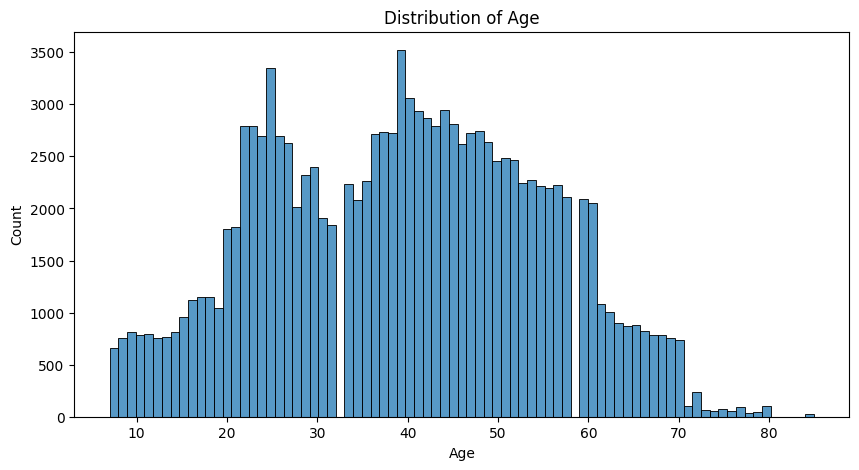

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(WRK_set['Age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show()

In [27]:
WRK_set['Age'].describe()

count    123386.000000
mean         39.413288
std          15.117348
min           7.000000
25%          27.000000
50%          40.000000
75%          51.000000
max          85.000000
Name: Age, dtype: float64

In [28]:
WRK_set.groupby("satisfaction_result")['Age'].mean()

satisfaction_result
neutral or dissatisfied    37.639333
satisfied                  41.722406
Name: Age, dtype: float64

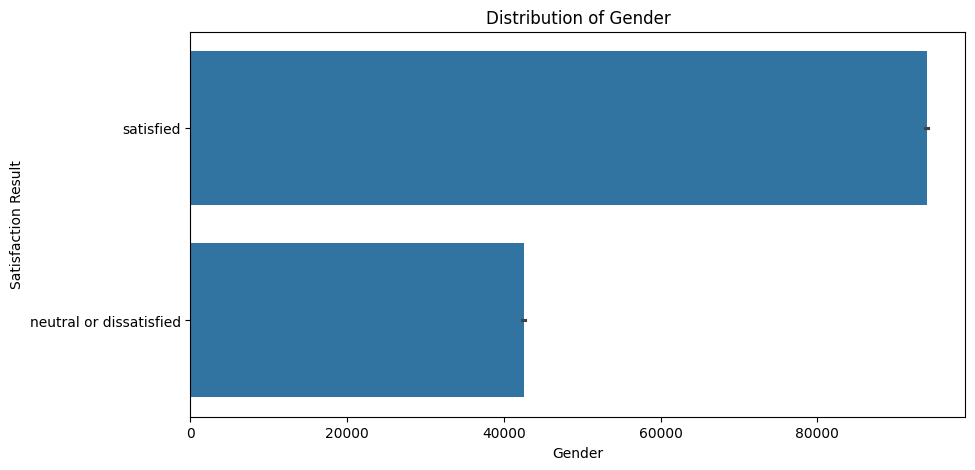

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(WRK_set['satisfaction_result'])
plt.xlabel('Gender')
plt.ylabel('Satisfaction Result')
plt.title('Distribution of Gender')
plt.show()

In [30]:
WRK_set['Age'].value_counts(ascending=False)

Age
39    3521
25    3349
40    3062
44    2949
41    2938
      ... 
76      57
74      52
79      50
78      40
85      23
Name: count, Length: 75, dtype: int64

In [31]:
service_cols = ['Inflight wifi service',
                'Departure/Arrival time convenient',
                'Gate location',
                'Food and drink',
                'Online Check-in',
                'Online Booking',
                'Seat comfort',
                'Inflight entertainment',
                'On-board service',
                'Leg room service',
                'Baggage handling',
                'Checkin service',
                'Inflight service']

print(WRK_set.groupby('satisfaction_result')[service_cols].mean().T)

satisfaction_result                neutral or dissatisfied  satisfied
Inflight wifi service                             2.397885   3.157554
Departure/Arrival time convenient                 3.131487   2.964035
Gate location                                     2.980739   2.973828
Food and drink                                    2.956649   3.524390
Online Check-in                                   2.659410   4.028280
Online Booking                                    2.548861   3.026713
Seat comfort                                      3.036773   3.965751
Inflight entertainment                            2.891457   3.962598
On-board service                                  3.020379   3.855896
Leg room service                                  2.989610   3.817990
Baggage handling                                  3.375414   3.965676
Checkin service                                   3.042606   3.650829
Inflight service                                  3.390734   3.969314


In [32]:
# Convert binary target to numeric if not already
WRK_set['sat_binary'] = WRK_set['satisfaction_result'].replace(
    {'satisfied': 1, 'neutral or dissatisfied': 0}
)

corr = WRK_set[service_cols + ['sat_binary']].corr()['sat_binary'].sort_values(ascending=False)
print(corr)

sat_binary                           1.000000
Online Check-in                      0.502710
Inflight entertainment               0.398053
Seat comfort                         0.349046
On-board service                     0.322087
Leg room service                     0.311859
Inflight wifi service                0.283332
Baggage handling                     0.248010
Inflight service                     0.243705
Checkin service                      0.238153
Food and drink                       0.211652
Online Booking                       0.169065
Gate location                       -0.002681
Departure/Arrival time convenient   -0.054387
Name: sat_binary, dtype: float64


#### Flight Distance

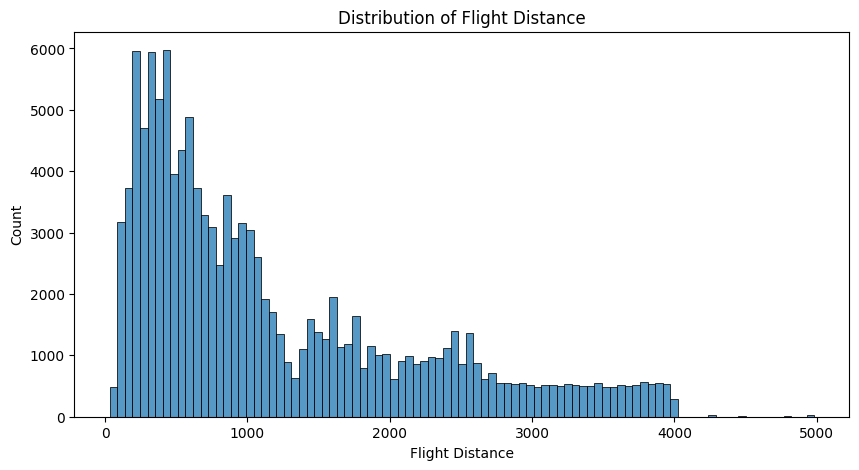

In [33]:
plt.figure(figsize=(10,5))
sns.histplot(WRK_set['Flight Distance'])
plt.xlabel('Flight Distance')
plt.ylabel('Count')
plt.title('Distribution of Flight Distance')
plt.show()

In [34]:
WRK_set['Flight Distance'].describe()

count    123386.000000
mean       1190.216986
std         996.677327
min          31.000000
25%         414.000000
50%         845.000000
75%        1744.000000
max        4983.000000
Name: Flight Distance, dtype: float64

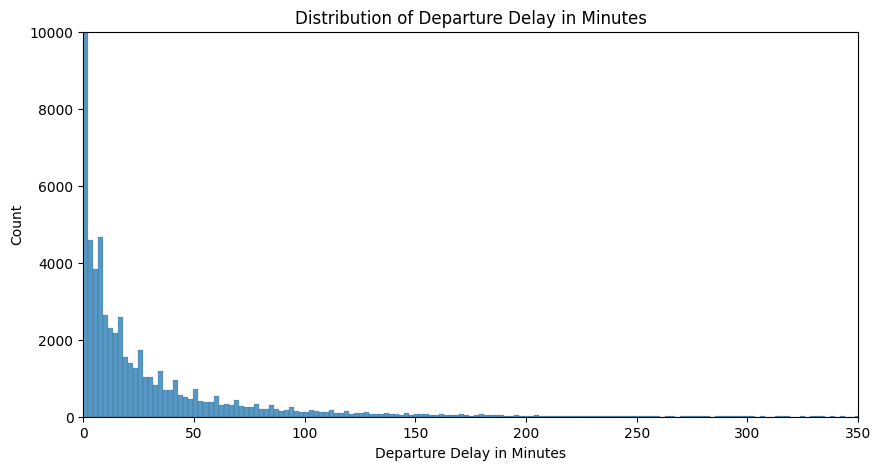

In [35]:
plt.figure(figsize=(10,5))
sns.histplot(WRK_set['Departure Delay in Minutes'])
plt.xlabel('Departure Delay in Minutes')
plt.ylabel('Count')
plt.title('Distribution of Departure Delay in Minutes')
plt.ylim(0, 10000) # Adjusting the y-axis limit for better visualization
plt.xlim(0, 350)
plt.show()

In [36]:
WRK_set['Departure Delay in Minutes'].describe()

count    123386.000000
mean         14.723858
std          38.130129
min           0.000000
25%           0.000000
50%           0.000000
75%          12.000000
max        1592.000000
Name: Departure Delay in Minutes, dtype: float64

### Looking at Categorical Variables

#### Gender

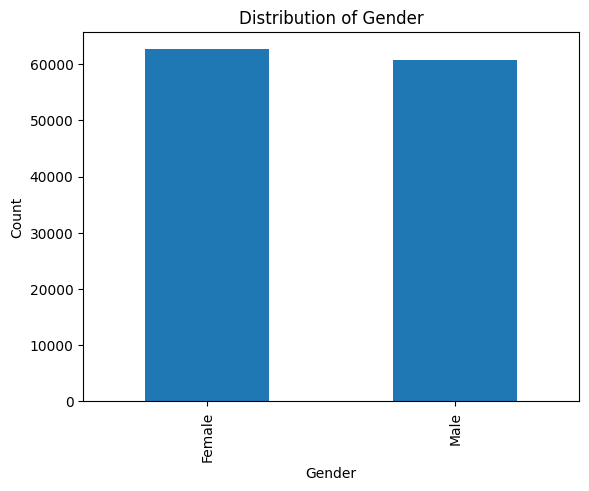

In [37]:
WRK_set['Gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')
plt.show()

In [38]:
WRK_set['Gender'].value_counts()

Gender
Female    62591
Male      60795
Name: count, dtype: int64

#### Customer Type

Looking at the distribution of the variable (i.e. Frequent Flyer vs Infrequent Flyer)

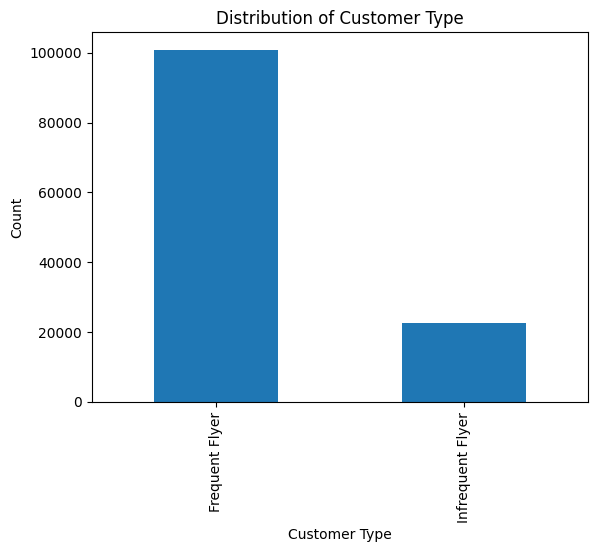

In [39]:
WRK_set['Customer Type'].value_counts().plot(kind='bar')
plt.xlabel('Customer Type')
plt.ylabel('Count')
plt.title('Distribution of Customer Type')
plt.show()

In [40]:
WRK_set['Customer Type'].unique()

array(['Infrequent Flyer', 'Frequent Flyer'], dtype=object)

In [41]:
freq_cx_count = 0
non_freq_cx_count = 0

for i in WRK_set['Customer Type']:
  if i == 'Frequent Flyer':
    freq_cx_count += 1
  else:
    non_freq_cx_count += 1

total_cx_count = freq_cx_count + non_freq_cx_count

per_freq = 100 * freq_cx_count / total_cx_count
per_freq_loyal = 100 * non_freq_cx_count / total_cx_count

print(f"Count of frequent flyers are {freq_cx_count} with percentage of {per_freq:.2f}%" )
print(f"Count of infrequent flyers are {non_freq_cx_count} with percentage of {per_freq_loyal:.2f}%")
print(f"Total count of customers are {total_cx_count}")

Count of frequent flyers are 100822 with percentage of 81.71%
Count of infrequent flyers are 22564 with percentage of 18.29%
Total count of customers are 123386


#### Class

Looking a the distribution of the classes (Business, Economic, Ecomonic Plus)

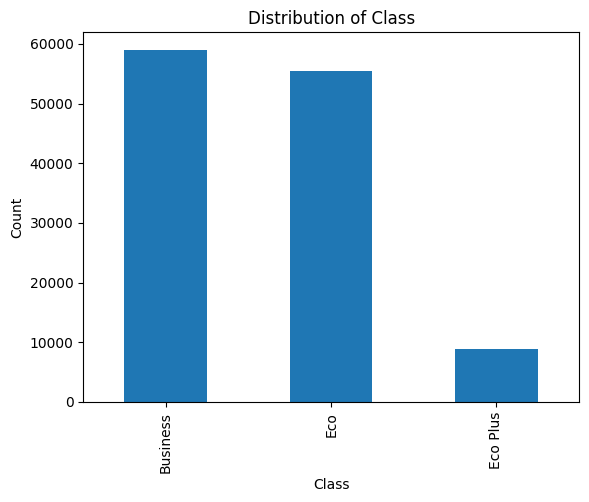

In [42]:
WRK_set['Class'].value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Class')
plt.show()

In [43]:
WRK_set['Class'].value_counts()

Class
Business    59000
Eco         55465
Eco Plus     8921
Name: count, dtype: int64

In [44]:
biz_count = 0
eco_count = 0
eco_plus_count = 0

for i in WRK_set['Class']:
  if i == 'Business':
    biz_count += 1
  elif i == 'Eco':
    eco_count += 1
  else:
    eco_plus_count += 1

total_cx_count = biz_count + eco_count + eco_plus_count

biz_freq = 100 * biz_count / total_cx_count
eco_freq = 100 * eco_count / total_cx_count
eco_plus_freq = 100 * eco_plus_count / total_cx_count

print(f"Count of Business Class flyers are {biz_count} with percentage of {biz_freq:.2f}%" )
print(f"Count of Ecomonic Class flyers are {eco_count} with percentage of {eco_freq:.2f}%")
print(f"Count of Ecomonic Plus Class flyers are {eco_plus_count} with percentage of {eco_plus_freq:.2f}%")
print(f"Total count of customers are {total_cx_count}")

Count of Business Class flyers are 59000 with percentage of 47.82%
Count of Ecomonic Class flyers are 55465 with percentage of 44.95%
Count of Ecomonic Plus Class flyers are 8921 with percentage of 7.23%
Total count of customers are 123386


#### Type of Travelling

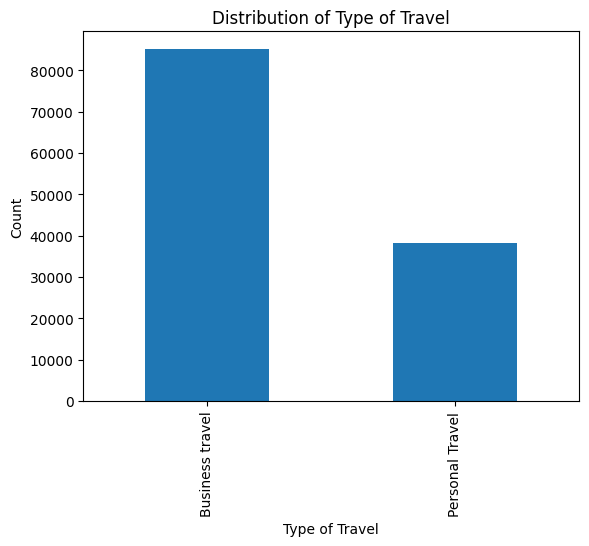

In [45]:
WRK_set['Type of Travel'].value_counts().plot(kind='bar')
plt.xlabel('Type of Travel')
plt.ylabel('Count')
plt.title('Distribution of Type of Travel')
plt.show()

In [46]:
WRK_set['Type of Travel'].value_counts()

Type of Travel
Business travel    85157
Personal Travel    38229
Name: count, dtype: int64

In [47]:
bizt_count = 0
personalt_count = 0

for i in WRK_set['Type of Travel']:
  if i == 'Business travel':
    bizt_count += 1
  else:
    personalt_count += 1

total_cx_count = bizt_count + personalt_count

bizt_freq = 100 * bizt_count / total_cx_count
personalt_freq = 100 * personalt_count / total_cx_count

print(f"Count of Business Travel are {bizt_count} with percentage of {bizt_freq:.2f}%" )
print(f"Count of Personal Travel are {personalt_count} with percentage of {personalt_freq:.2f}%")
print(f"Total count of customers are {total_cx_count}")

Count of Business Travel are 85157 with percentage of 69.02%
Count of Personal Travel are 38229 with percentage of 30.98%
Total count of customers are 123386


## <font color = orange> 5. Descriptive Analysis on the 14 service touchpoints </font> 

### <font color=Yellow> Satisfaction Rate Plot Distribution for each touchpoint </font>

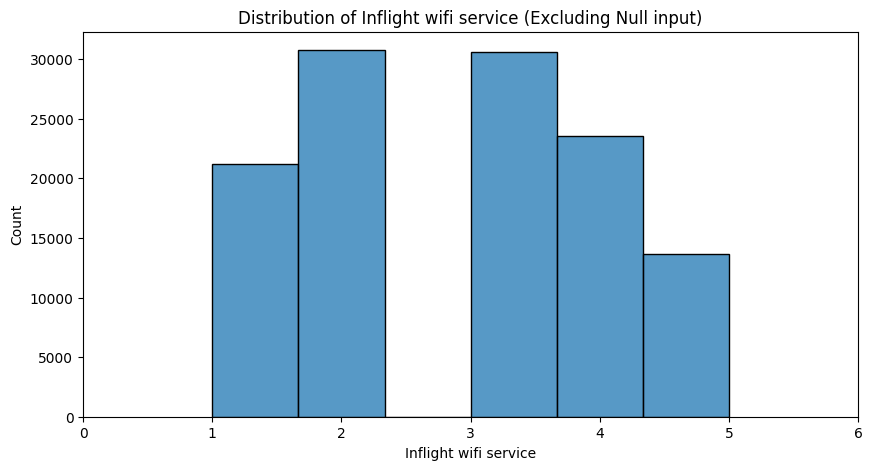

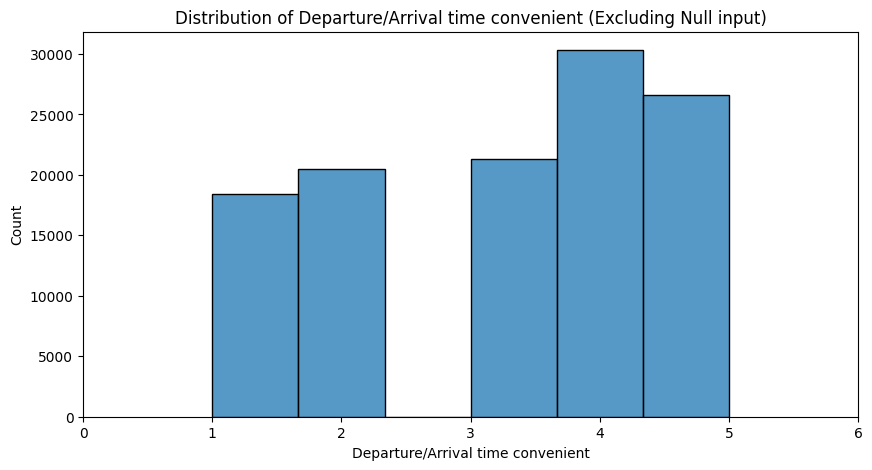

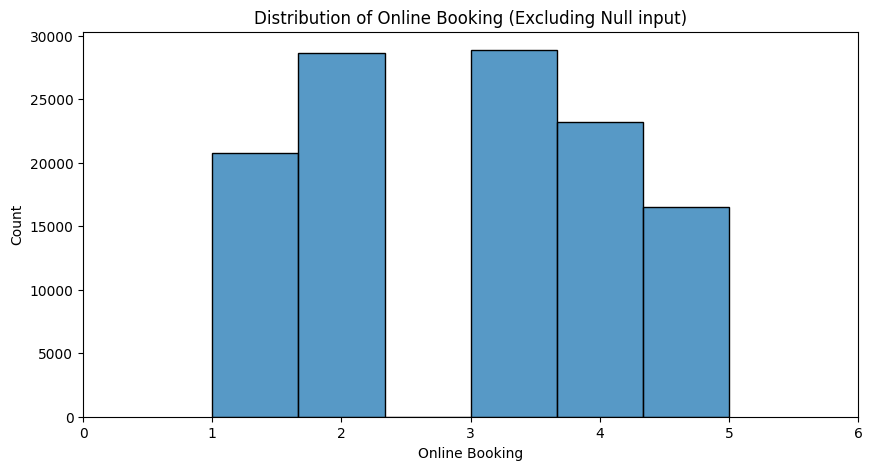

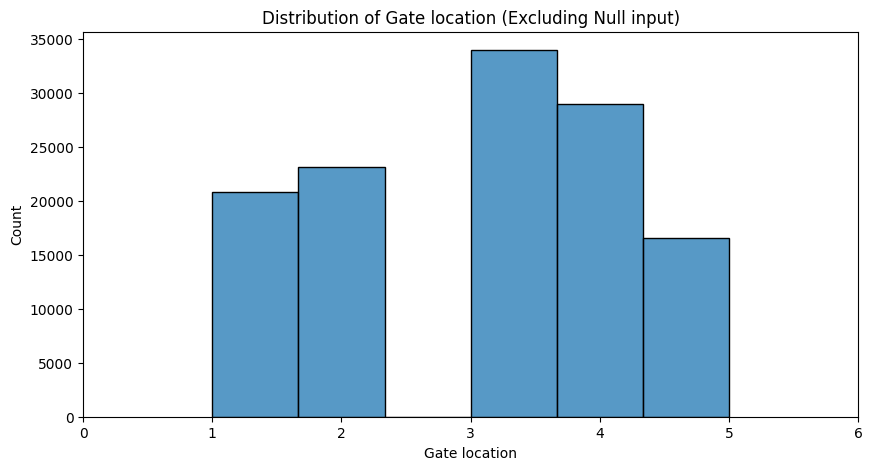

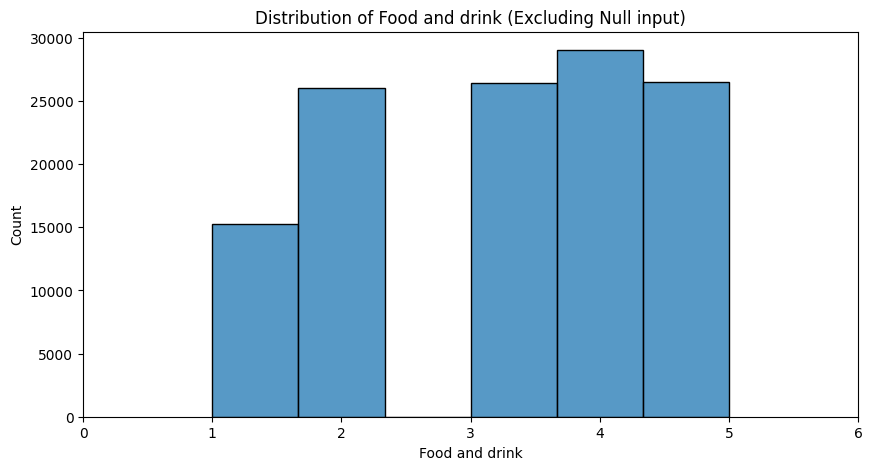

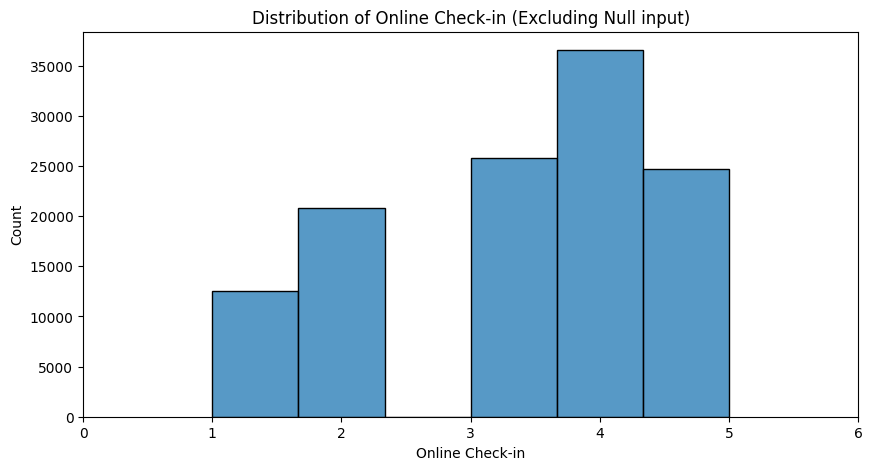

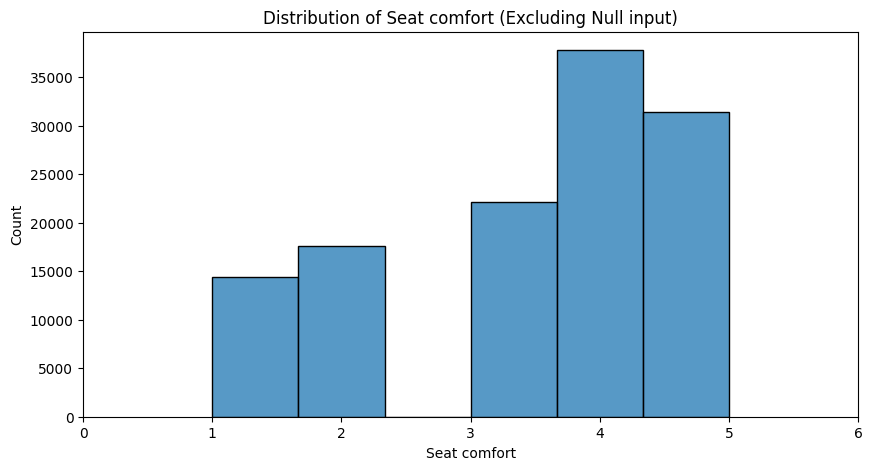

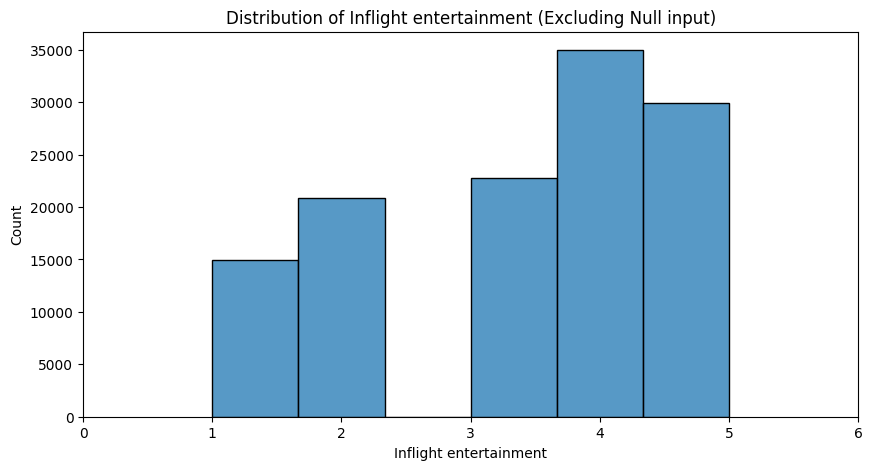

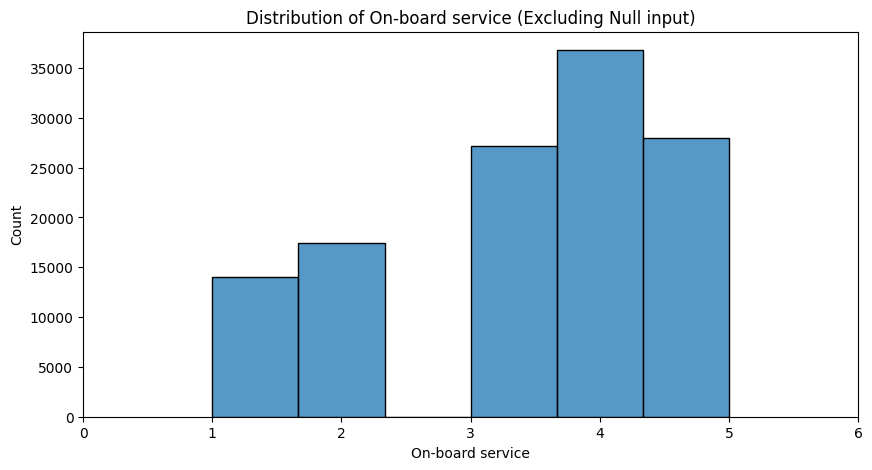

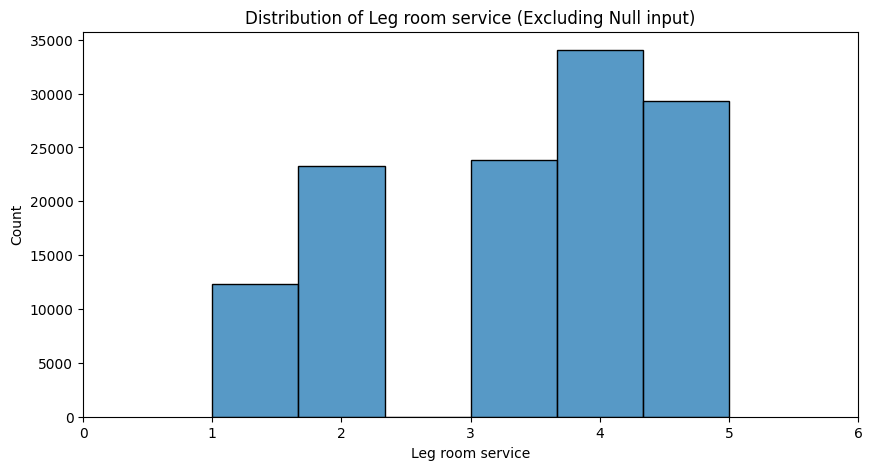

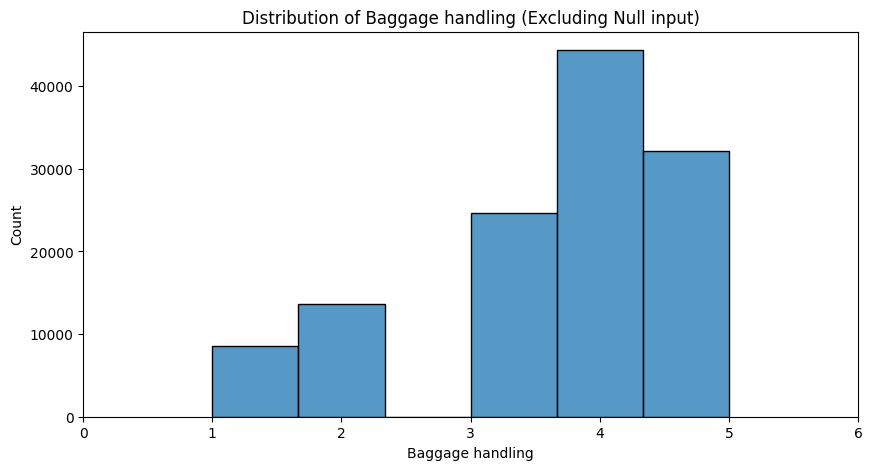

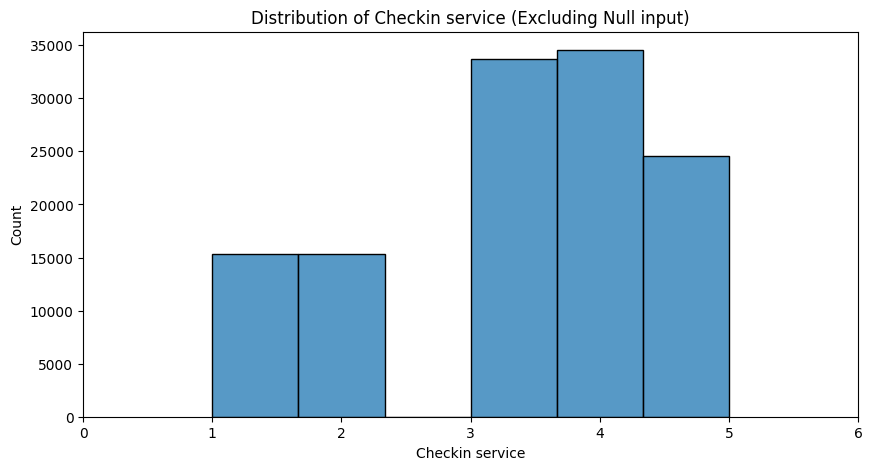

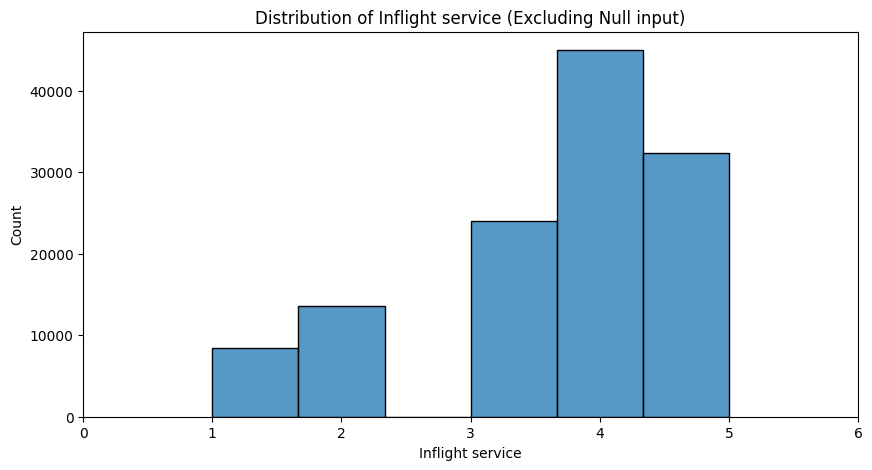

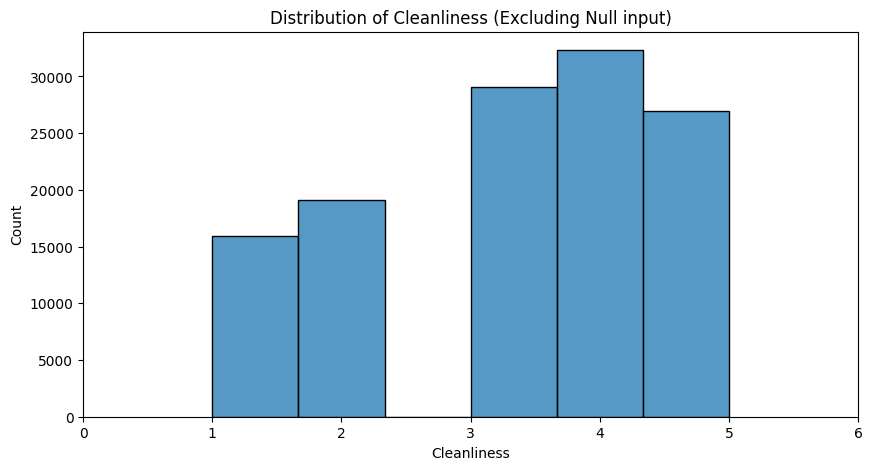

In [48]:
sat_lvl_columns = ['Inflight wifi service',
                  'Departure/Arrival time convenient',
                  'Online Booking',
                  'Gate location',
                  'Food and drink',
                  'Online Check-in',
                  'Seat comfort',
                  'Inflight entertainment',
                  'On-board service',
                  'Leg room service',
                  'Baggage handling',
                  'Checkin service',
                  'Inflight service',
                  'Cleanliness',
                   ]

for c in sat_lvl_columns:
  plt.figure(figsize=(10,5))
  filtered_data = WRK_set[WRK_set[c] != 0]
  sns.histplot(filtered_data[c], binwidth=0.7)
  plt.xlabel(c)
  plt.ylabel('Count')
  plt.xlim(0, 6)
  plt.title(f'Distribution of {c} (Excluding Null input)')
  plt.show()

### <font color=Yellow> Descriptive Scores for each satisfaction level </font>

In [49]:
for c in sat_lvl_columns:
  filtered_data = WRK_set[WRK_set[c] != 0]
  filter_per = filtered_data[c].value_counts(normalize=True)*100
  mean_score = filtered_data[c].mean()
  highest_score = filter_per.idxmax()
  max_percentage = filter_per.max()
  total_count = filtered_data[c].count()
  display(f"The highest score for {c} is {highest_score} at {max_percentage:.2f}%")
  display(f"The total input for {c} column is {total_count}")
  display(f"The mean score for {c} is {mean_score:.1f}")

'The highest score for Inflight wifi service is 2 at 25.71%'

'The total input for Inflight wifi service column is 119652'

'The mean score for Inflight wifi service is 2.8'

'The highest score for Departure/Arrival time convenient is 4 at 25.91%'

'The total input for Departure/Arrival time convenient column is 117040'

'The mean score for Departure/Arrival time convenient is 3.2'

'The highest score for Online Booking is 3 at 24.47%'

'The total input for Online Booking column is 117991'

'The mean score for Online Booking is 2.9'

'The highest score for Gate location is 3 at 27.53%'

'The total input for Gate location column is 123385'

'The mean score for Gate location is 3.0'

'The highest score for Food and drink is 4 at 23.55%'

'The total input for Food and drink column is 123263'

'The mean score for Food and drink is 3.2'

'The highest score for Online Check-in is 4 at 30.36%'

'The total input for Online Check-in column is 120484'

'The mean score for Online Check-in is 3.3'

'The highest score for Seat comfort is 4 at 30.63%'

'The total input for Seat comfort column is 123385'

'The mean score for Seat comfort is 3.4'

'The highest score for Inflight entertainment is 4 at 28.34%'

'The total input for Inflight entertainment column is 123370'

'The mean score for Inflight entertainment is 3.4'

'The highest score for On-board service is 4 at 29.82%'

'The total input for On-board service column is 123382'

'The mean score for On-board service is 3.4'

'The highest score for Leg room service is 4 at 27.72%'

'The total input for Leg room service column is 122811'

'The mean score for Leg room service is 3.4'

'The highest score for Baggage handling is 4 at 35.97%'

'The total input for Baggage handling column is 123386'

'The mean score for Baggage handling is 3.6'

'The highest score for Checkin service is 4 at 28.00%'

'The total input for Checkin service column is 123385'

'The mean score for Checkin service is 3.3'

'The highest score for Inflight service is 4 at 36.46%'

'The total input for Inflight service column is 123382'

'The mean score for Inflight service is 3.6'

'The highest score for Cleanliness is 4 at 26.20%'

'The total input for Cleanliness column is 123373'

'The mean score for Cleanliness is 3.3'

In [50]:
for c in sat_lvl_columns:
  filtered_data = WRK_set[WRK_set[c] != 0]
  mean_score = filtered_data[c].mean()
  display(f"The mean score for {c} is {mean_score:.1f}")

'The mean score for Inflight wifi service is 2.8'

'The mean score for Departure/Arrival time convenient is 3.2'

'The mean score for Online Booking is 2.9'

'The mean score for Gate location is 3.0'

'The mean score for Food and drink is 3.2'

'The mean score for Online Check-in is 3.3'

'The mean score for Seat comfort is 3.4'

'The mean score for Inflight entertainment is 3.4'

'The mean score for On-board service is 3.4'

'The mean score for Leg room service is 3.4'

'The mean score for Baggage handling is 3.6'

'The mean score for Checkin service is 3.3'

'The mean score for Inflight service is 3.6'

'The mean score for Cleanliness is 3.3'

In [51]:
for c in sat_lvl_columns:
  # Create a new column with '_satisfaction' suffix
  new_col_name = f'{c}_satisfaction'
  WRK_set[new_col_name] = WRK_set[c].apply(lambda x: 'Satisfied' if x > 3 else 'Neutral or Dissatisfied')
  print(f"Satisfaction categories for {c}:")
  display(WRK_set[new_col_name].value_counts())

Satisfaction categories for Inflight wifi service:


Inflight wifi service_satisfaction
Neutral or Dissatisfied    86257
Satisfied                  37129
Name: count, dtype: int64

Satisfaction categories for Departure/Arrival time convenient:


Departure/Arrival time convenient_satisfaction
Neutral or Dissatisfied    66469
Satisfied                  56917
Name: count, dtype: int64

Satisfaction categories for Online Booking:


Online Booking_satisfaction
Neutral or Dissatisfied    83641
Satisfied                  39745
Name: count, dtype: int64

Satisfaction categories for Gate location:


Gate location_satisfaction
Neutral or Dissatisfied    77908
Satisfied                  45478
Name: count, dtype: int64

Satisfaction categories for Food and drink:


Food and drink_satisfaction
Neutral or Dissatisfied    67857
Satisfied                  55529
Name: count, dtype: int64

Satisfaction categories for Online Check-in:


Online Check-in_satisfaction
Neutral or Dissatisfied    62078
Satisfied                  61308
Name: count, dtype: int64

Satisfaction categories for Seat comfort:


Seat comfort_satisfaction
Satisfied                  69242
Neutral or Dissatisfied    54144
Name: count, dtype: int64

Satisfaction categories for Inflight entertainment:


Inflight entertainment_satisfaction
Satisfied                  64869
Neutral or Dissatisfied    58517
Name: count, dtype: int64

Satisfaction categories for On-board service:


On-board service_satisfaction
Satisfied                  64767
Neutral or Dissatisfied    58619
Name: count, dtype: int64

Satisfaction categories for Leg room service:


Leg room service_satisfaction
Satisfied                  63378
Neutral or Dissatisfied    60008
Name: count, dtype: int64

Satisfaction categories for Baggage handling:


Baggage handling_satisfaction
Satisfied                  76561
Neutral or Dissatisfied    46825
Name: count, dtype: int64

Satisfaction categories for Checkin service:


Checkin service_satisfaction
Neutral or Dissatisfied    64249
Satisfied                  59137
Name: count, dtype: int64

Satisfaction categories for Inflight service:


Inflight service_satisfaction
Satisfied                  77335
Neutral or Dissatisfied    46051
Name: count, dtype: int64

Satisfaction categories for Cleanliness:


Cleanliness_satisfaction
Neutral or Dissatisfied    64118
Satisfied                  59268
Name: count, dtype: int64

In [52]:
# For reference, Group 1 -3 as Neutral or Disatisfied and 4-5 as Satisfied

nd_count = 0
s_count = 0

for i in WRK_set['Inflight service']:
  if i <=3:
    nd_count += 1
  else:
    s_count +=1

total_count = nd_count + s_count

nd_freq = 100*nd_count/total_count
s_freq = 100*s_count/total_count

print(f"There are {nd_count} of people rated Neutral or Dissatisfied, which is {nd_freq:.2f}% of the total responses")
print(f"There are {s_count} of people rated Satisfied, which is {s_freq:.2f}% of the total responses")
print(f"Total responses for Inflight Service is {total_count} ({100*total_count/WRK_set['Inflight wifi service'].count():.1f}%), with {WRK_set['Inflight wifi service'].count() - total_count} of NULL respond")

There are 46051 of people rated Neutral or Dissatisfied, which is 37.32% of the total responses
There are 77335 of people rated Satisfied, which is 62.68% of the total responses
Total responses for Inflight Service is 123386 (100.0%), with 0 of NULL respond


In [53]:
filtered_data

,satisfaction_result,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Online Booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,sat_binary
0,satisfied,Male,Infrequent Flyer,56,Personal Travel,Eco,369,0,2,0,...,3,3,1,5,3,3,4,3,0,1
1,satisfied,Male,Infrequent Flyer,49,Personal Travel,Eco,2486,0,2,1,...,3,2,1,1,4,4,3,2,0,1
2,satisfied,Male,Infrequent Flyer,55,Personal Travel,Eco,1448,0,3,0,...,3,3,3,5,3,2,3,3,0,1
3,satisfied,Female,Infrequent Flyer,36,Personal Travel,Eco,1501,0,4,0,...,4,4,5,4,5,5,5,4,0,1
4,satisfied,Male,Infrequent Flyer,55,Personal Travel,Eco,577,0,5,0,...,3,3,3,4,5,3,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,Female,Frequent Flyer,35,Business travel,Business,2592,5,5,5,...,4,5,5,5,5,5,5,4,0,1
129876,satisfied,Female,Frequent Flyer,11,Business travel,Eco,610,5,1,1,...,5,5,5,4,1,2,5,5,82,1
129877,satisfied,Male,Frequent Flyer,46,Business travel,Business,86,1,1,1,...,5,5,1,3,1,5,2,2,0,1
129878,satisfied,Female,Frequent Flyer,35,Business travel,Business,83,1,1,1,...,5,5,4,4,2,5,5,5,0,1


# <font color = orange> 6. Importance Weightage </font>

### Logistic Regression (all columns)

In [55]:
cat_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

cat_col = pd.get_dummies(WRK_set[cat_columns], drop_first=False)

num_col = ['Age',
            'Flight Distance',
            'Inflight wifi service',
            'Departure/Arrival time convenient',
            'Online Booking',
            'Gate location',
            'Food and drink',
            'Online Check-in',
            'Seat comfort',
            'Inflight entertainment',
            'On-board service',
            'Leg room service',
            'Baggage handling',
            'Checkin service',
            'Inflight service',
            'Cleanliness',
            'Departure Delay in Minutes']

WRK_set['sat_binary'] = WRK_set['satisfaction_result'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})

X = pd.concat([WRK_set[num_col], cat_col], axis=1)
y = WRK_set['sat_binary']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


#### **Accurary Score**

In [58]:
y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8152420574886535
              precision    recall  f1-score   support

           0       0.86      0.81      0.83     21101
           1       0.76      0.83      0.79     15915

    accuracy                           0.82     37016
   macro avg       0.81      0.82      0.81     37016
weighted avg       0.82      0.82      0.82     37016



#### **Confussion Matrix**
The analysis will be looking at the following:
<br>*False Positive* & *Fasle Negative*
<br>*Type 1 error* - This occurs when the test predicts a customer is satisfied with the overall customer journey (positive result) but the patient is actually not satisfied or neutral with the experience (negative case).
<br>*Type 2 error* - This occurs when the test predicts a customer is dissatisfied or neutral with our experience  (negative result) but the patient actually is satisfied (positive case).

In [59]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[17013  4088]
 [ 2751 13164]]


In [60]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.88


In [61]:
intercept = lr.intercept_[0]

coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_[0]
})

coefs_sorted = coefs.sort_values(by="Coefficient", ascending=False)

print("Intercept (β0):", intercept, "\n")
print(coefs_sorted)

Intercept (β0): -0.320655911462345 

                              Feature  Coefficient
7                     Online Check-in     0.742143
23                     Class_Business     0.501679
2               Inflight wifi service     0.433754
21     Type of Travel_Business travel     0.326354
9              Inflight entertainment     0.309009
10                   On-board service     0.199124
11                   Leg room service     0.152793
4                      Online Booking     0.080834
8                        Seat comfort     0.025616
19       Customer Type_Frequent Flyer     0.017975
1                     Flight Distance     0.000023
16         Departure Delay in Minutes    -0.006763
13                    Checkin service    -0.016830
0                                 Age    -0.022409
15                        Cleanliness    -0.073662
25                     Class_Eco Plus    -0.099040
18                        Gender_Male    -0.126097
12                   Baggage handling    -0.1

## <font color = green> Logisctic Regression Model (service touch points only)

In [62]:
num_col_tp = ['Inflight wifi service',
            'Departure/Arrival time convenient',
            'Online Booking',
            'Gate location',
            'Food and drink',
            'Online Check-in',
            'Seat comfort',
            'Inflight entertainment',
            'On-board service',
            'Leg room service',
            'Baggage handling',
            'Checkin service',
            'Inflight service',
            'Cleanliness'
            ]

WRK_set['sat_binary'] = WRK_set['satisfaction_result'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})

X = pd.concat([WRK_set[num_col_tp]], axis=1)
y = WRK_set['sat_binary']

In [63]:
X_train_tp, X_test_tp, y_train_tp, y_test_tp = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
lr = LogisticRegression()
lr.fit(X_train_tp, y_train_tp)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [65]:
y_pred_tp = lr.predict(X_test_tp)
y_pred_prob_tp = lr.predict_proba(X_test_tp)[:, 1]

print("Accuracy:", accuracy_score(y_test_tp, y_pred_tp))
print(classification_report(y_test_tp, y_pred_tp))

Accuracy: 0.8148368273179166
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     21101
           1       0.79      0.77      0.78     15915

    accuracy                           0.81     37016
   macro avg       0.81      0.81      0.81     37016
weighted avg       0.81      0.81      0.81     37016



In [66]:
intercept = lr.intercept_[0]

coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_[0]
})

coefs_sorted = coefs.sort_values(by="Coefficient", ascending=False)

print("Intercept (β0):", intercept, "\n")
print(coefs_sorted)

Intercept (β0): -7.643494502611926 

                              Feature  Coefficient
5                     Online Check-in     0.821239
9                    Leg room service     0.354970
0               Inflight wifi service     0.312587
7              Inflight entertainment     0.285849
8                    On-board service     0.280044
11                    Checkin service     0.228744
6                        Seat comfort     0.148473
3                       Gate location     0.122205
13                        Cleanliness     0.052373
10                   Baggage handling     0.048280
12                   Inflight service     0.021489
4                      Food and drink    -0.062710
2                      Online Booking    -0.136548
1   Departure/Arrival time convenient    -0.305627


In [67]:
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"ROC AUC Score: {roc_auc}")
print("Confusion Matrix:\n", cm)

ROC AUC Score: 0.877250975042866
Confusion Matrix:
 [[17013  4088]
 [ 2751 13164]]


## <font color = yellow> **Random Forest** on the touch points only</font>

In [68]:
rf = RandomForestClassifier()
rf.fit(X_train_tp, y_train_tp)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [69]:
y_pred_rf = rf.predict(X_test_tp)
y_pred_prob_rf = rf.predict_proba(X_test_tp)[:, 1]

### Accuracy Score & Confusion Matrix for Random Forest

In [70]:
print("Accuracy Score:\n", accuracy_score(y_test_tp, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_tp, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_tp, y_pred_rf))
print("\nROC-AUC Score:", roc_auc_score(y_test_tp, y_pred_prob_rf))
print("Mean Square Error:", mean_squared_error(y_test_tp, y_pred_rf))

Accuracy Score:
 0.9450507888480657

Confusion Matrix:
 [[20305   796]
 [ 1238 14677]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     21101
           1       0.95      0.92      0.94     15915

    accuracy                           0.95     37016
   macro avg       0.95      0.94      0.94     37016
weighted avg       0.95      0.95      0.94     37016


ROC-AUC Score: 0.9869127854375056
Mean Square Error: 0.054949211151934296


In [71]:
importance_rf = rf.feature_importances_
feature_names_rf = X_train_tp.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names_rf, 'Importance': importance_rf})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_df_rf)

                              Feature  Importance
5                     Online Check-in    0.223697
0               Inflight wifi service    0.171331
9                    Leg room service    0.082180
7              Inflight entertainment    0.076446
1   Departure/Arrival time convenient    0.062995
6                        Seat comfort    0.062301
2                      Online Booking    0.056149
8                    On-board service    0.048104
3                       Gate location    0.042537
10                   Baggage handling    0.042525
11                    Checkin service    0.035313
12                   Inflight service    0.034001
13                        Cleanliness    0.032374
4                      Food and drink    0.030045


# **XGBoost** (all variables)

In [72]:
dtrain_a = xgb.DMatrix(X_train, label=y_train)
dtest_a = xgb.DMatrix(X_test, label=y_test)

In [73]:
model_xgba = xgb.XGBClassifier(random_state=42)
model_xgba.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [74]:
y_pred_xgba = model_xgba.predict(X_test)
y_pred_prob_xgba = model_xgba.predict_proba(X_test)[:, 1]
msr = mean_squared_error(y_test, y_pred_xgba)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgba))
print("\nAccuracy:", accuracy_score(y_test, y_pred_xgba))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgba))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_xgba))
print("Mean Squared Error:", msr)

Confusion Matrix:
 [[20639   462]
 [  914 15001]]

Accuracy: 0.9628268856710611

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     21101
           1       0.97      0.94      0.96     15915

    accuracy                           0.96     37016
   macro avg       0.96      0.96      0.96     37016
weighted avg       0.96      0.96      0.96     37016


ROC-AUC Score: 0.9949219947096146
Mean Squared Error: 0.037173114328938835


In [75]:
importances_xgba = model_xgba.feature_importances_
feature_names_xgba = X_train.columns
feature_importance_xgba_df = pd.DataFrame({'Feature': feature_names_xgba , 'Importance': importances_xgba})
feature_importance_xgba_df = feature_importance_xgba_df.sort_values(by='Importance', ascending=False)
print(feature_importance_xgba_df)

                              Feature  Importance
7                     Online Check-in    0.398581
21     Type of Travel_Business travel    0.149515
2               Inflight wifi service    0.106562
19       Customer Type_Frequent Flyer    0.066901
23                     Class_Business    0.047857
9              Inflight entertainment    0.036982
13                    Checkin service    0.028866
15                        Cleanliness    0.023498
5                       Gate location    0.018976
8                        Seat comfort    0.018965
11                   Leg room service    0.018833
10                   On-board service    0.017412
12                   Baggage handling    0.016854
14                   Inflight service    0.015722
3   Departure/Arrival time convenient    0.007006
0                                 Age    0.005587
4                      Online Booking    0.004937
16         Departure Delay in Minutes    0.003994
1                     Flight Distance    0.003283


In [76]:
import joblib
joblib.dump(model_xgba, './model_xgba.pkl')

['./model_xgba.pkl']

## **XGBoost** only Touch Point

In [77]:
dtrain = xgb.DMatrix(X_train_tp, label=y_train_tp)
dtest = xgb.DMatrix(X_test_tp, label=y_test_tp)

In [78]:
model_xgb = xgb.XGBClassifier(random_state=42)
model_xgb.fit(X_train_tp, y_train_tp)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [79]:
y_pred_xgb = model_xgb.predict(X_test_tp)
y_pred_prob_xgb = model_xgb.predict_proba(X_test_tp)[:, 1]
msr = mean_squared_error(y_test_tp, y_pred_xgb)

print("Confusion Matrix:\n", confusion_matrix(y_test_tp, y_pred_xgb))
print("\nAccuracy:", accuracy_score(y_test_tp, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test_tp, y_pred_xgb))
print("\nROC-AUC Score:", roc_auc_score(y_test_tp, y_pred_prob_xgb))
print("Mean Squared Error:", msr)

Confusion Matrix:
 [[20311   790]
 [ 1178 14737]]

Accuracy: 0.9468338015993084

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     21101
           1       0.95      0.93      0.94     15915

    accuracy                           0.95     37016
   macro avg       0.95      0.94      0.95     37016
weighted avg       0.95      0.95      0.95     37016


ROC-AUC Score: 0.9901363344075766
Mean Squared Error: 0.053166198400691596


In [80]:
joblib.dump(model_xgb, './model_xgb.pkl')

['./model_xgb.pkl']

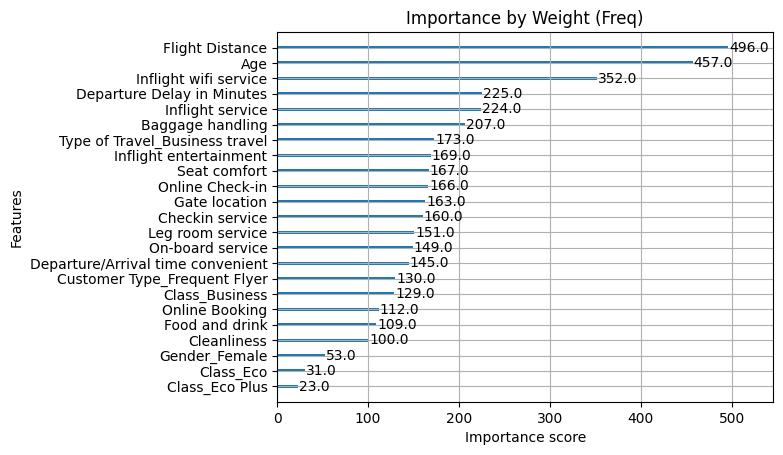

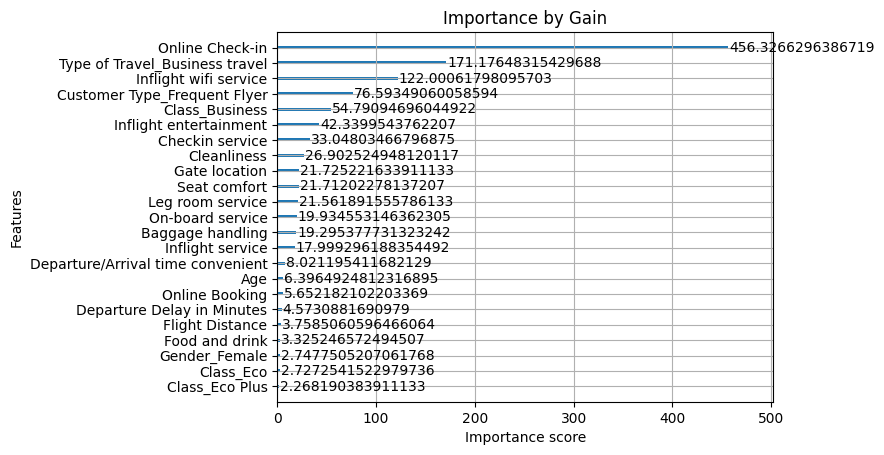

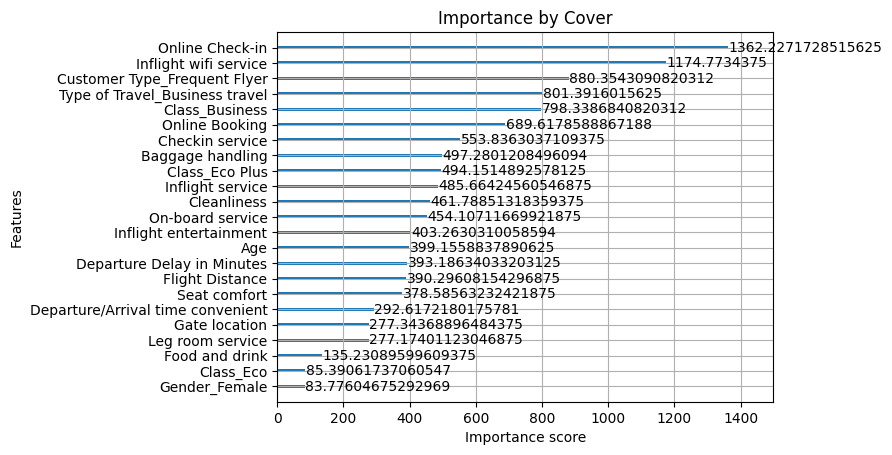

In [81]:
xgb.plot_importance(model_xgba, importance_type="weight")  # weight = frequency of use
plt.title("Importance by Weight (Freq)")
plt.show()

# Option 2: Other importance types
xgb.plot_importance(model_xgba, importance_type="gain")    # average gain when used
plt.title("Importance by Gain")
plt.show()

xgb.plot_importance(model_xgba, importance_type="cover")   # coverage of splits
plt.title("Importance by Cover")
plt.show()

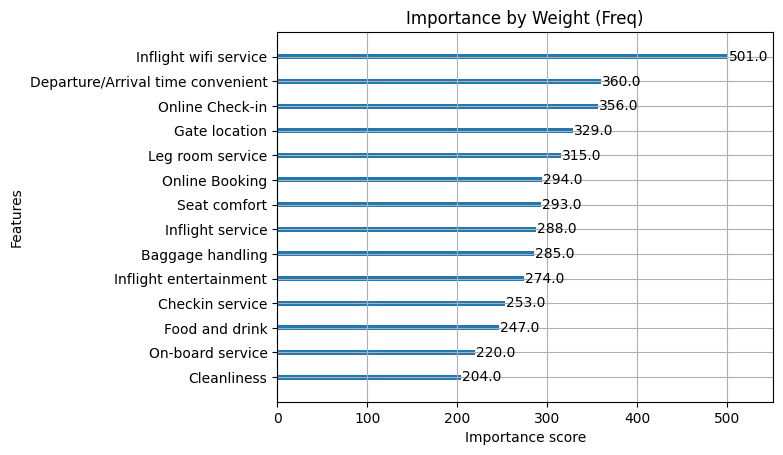

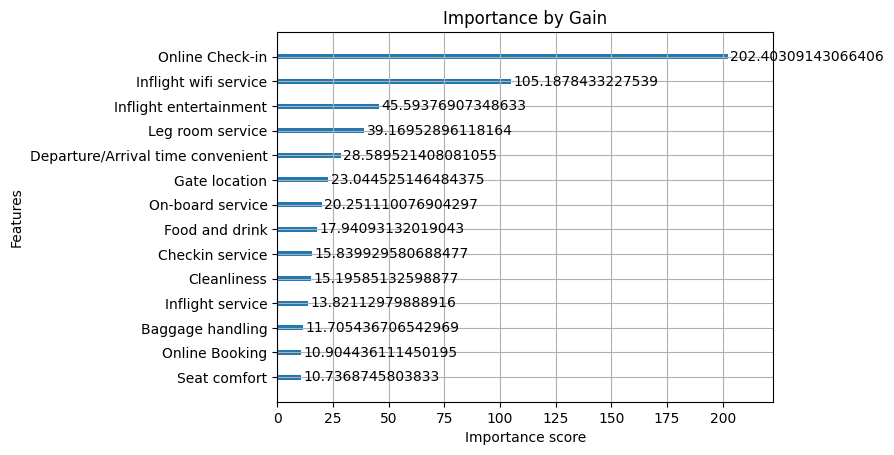

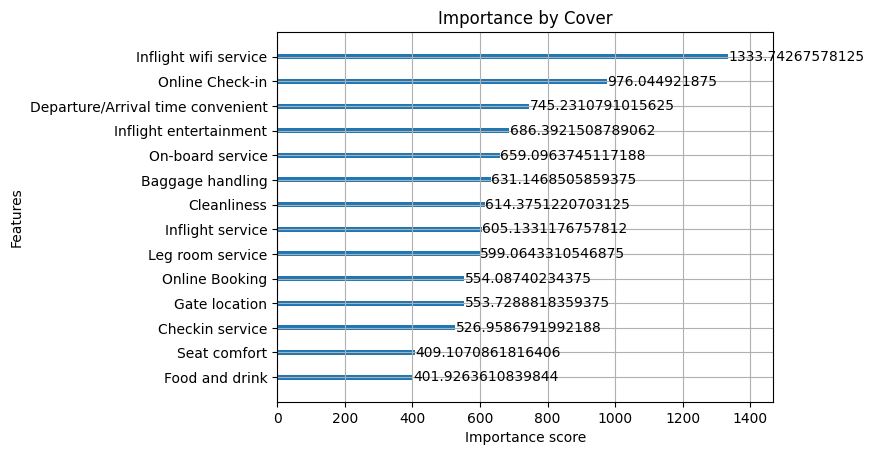

In [82]:
# Option 1: Built-in importance scores
xgb.plot_importance(model_xgb, importance_type="weight")  # weight = frequency of use
plt.title("Importance by Weight (Freq)")
plt.show()


# Option 2: Other importance types
xgb.plot_importance(model_xgb, importance_type="gain")    # average gain when used
plt.title("Importance by Gain")
plt.show()

xgb.plot_importance(model_xgb, importance_type="cover")   # coverage of splits
plt.title("Importance by Cover")
plt.show()

In [83]:
importances_xgb = model_xgb.feature_importances_
feature_names_xgb = X_train_tp.columns
feature_importance_xgb_df = pd.DataFrame({'Feature': feature_names_xgb , 'Importance': importances_xgb})
feature_importance_xgb_df = feature_importance_xgb_df.sort_values(by='Importance', ascending=False)
print(feature_importance_xgb_df)

                              Feature  Importance
5                     Online Check-in    0.361186
0               Inflight wifi service    0.187707
7              Inflight entertainment    0.081362
9                    Leg room service    0.069898
1   Departure/Arrival time convenient    0.051018
3                       Gate location    0.041123
8                    On-board service    0.036138
4                      Food and drink    0.032015
11                    Checkin service    0.028266
13                        Cleanliness    0.027117
12                   Inflight service    0.024664
10                   Baggage handling    0.020888
2                      Online Booking    0.019459
6                        Seat comfort    0.019160


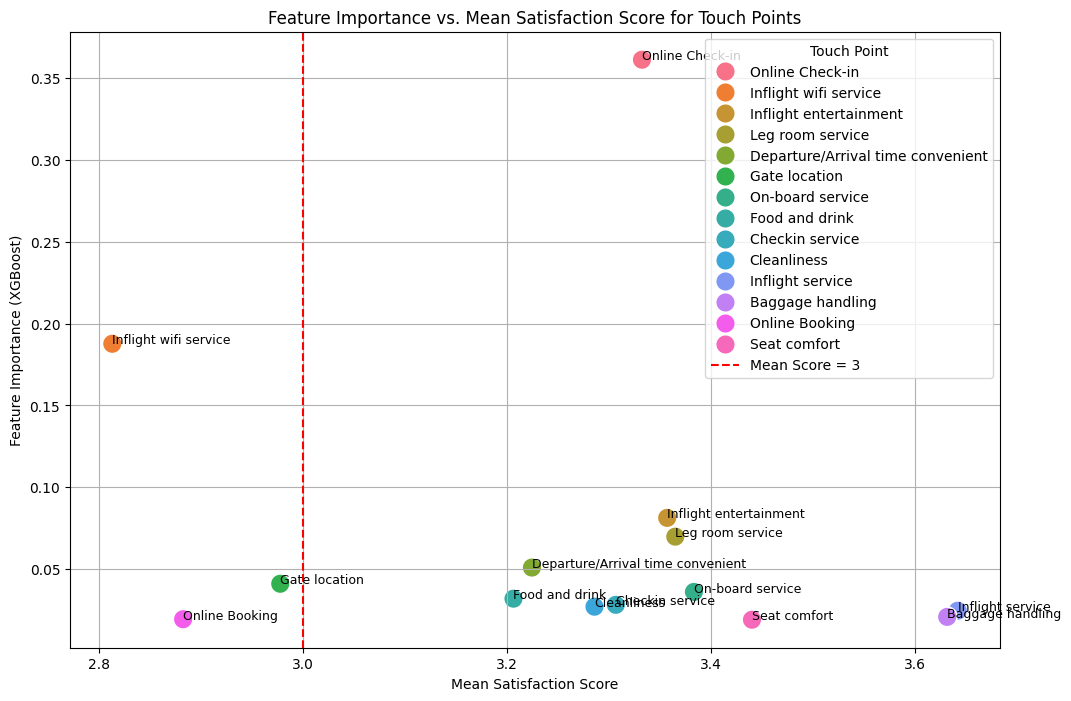

,Feature,Importance,Mean_Score
5,Online Check-in,0.361186,3.332517
0,Inflight wifi service,0.187707,2.813066
7,Inflight entertainment,0.081362,3.357267
9,Leg room service,0.069898,3.365195
1,Departure/Arrival time convenient,0.051018,3.224581
3,Gate location,0.041123,2.977761
8,On-board service,0.036138,3.383492
4,Food and drink,0.032015,3.206510
11,Checkin service,0.028266,3.306885
13,Cleanliness,0.027117,3.285946


In [84]:
# Create a DataFrame with touch point feature importances
feature_importance_xgb_df_tp = pd.DataFrame({
    'Feature': X_train_tp.columns,
    'Importance': model_xgb.feature_importances_
})

# Create a DataFrame with mean scores for each touch point
mean_scores_df = pd.DataFrame({
    'Feature': sat_lvl_columns,
    'Mean_Score': [WRK_set[c][WRK_set[c] != 0].mean() for c in sat_lvl_columns]
})

# Merge the two DataFrames
merged_df = pd.merge(feature_importance_xgb_df_tp, mean_scores_df, on='Feature')

# Sort by importance for better visualization
merged_df = merged_df.sort_values(by='Importance', ascending=False)

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='Mean_Score', y='Importance', hue='Feature', s=200)

# Add labels and title
plt.xlabel('Mean Satisfaction Score')
plt.ylabel('Feature Importance (XGBoost)')
plt.title('Feature Importance vs. Mean Satisfaction Score for Touch Points')

# Add annotations for each point
for i, row in merged_df.iterrows():
    plt.text(row['Mean_Score'], row['Importance'], row['Feature'], fontsize=9, ha='left')

# Add a vertical line at mean score 3
plt.axvline(x=3, color='red', linestyle='--', label='Mean Score = 3')
plt.legend(title='Touch Point')

# Show the plot
plt.grid(True)
plt.show()

display(merged_df)

In [85]:
y_pred_xgb

array([0, 0, 1, ..., 1, 1, 1], shape=(37016,))

# <font color = orange> 7. Holdout Data comparison </font>
Evaluate the trained models using the holdout dataset 'Hold Out_set.csv'.

### Load the holdout data

In [86]:
HO_set = pd.read_csv('Hold Out_set.csv')
display(HO_set.head())
display(HO_set.info())

,satisfaction_result,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Online Booking,...,Online Check-in,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes
0,neutral or dissatisfied,Female,Frequent Flyer,21,Personal Travel,Business,483,1,0,1,...,1,1,1,3,5,4,4,4,1,0
1,neutral or dissatisfied,Male,Frequent Flyer,61,Personal Travel,Eco,944,3,4,3,...,3,5,4,3,3,1,1,2,4,0
2,neutral or dissatisfied,Male,Infrequent Flyer,27,Business travel,Business,1199,1,1,1,...,1,3,3,4,5,5,3,4,3,0
3,neutral or dissatisfied,Male,Frequent Flyer,70,Business travel,Eco,201,2,1,5,...,2,2,2,3,4,3,3,3,2,0
4,neutral or dissatisfied,Female,Frequent Flyer,38,Business travel,Eco,616,4,5,5,...,4,4,4,1,2,4,2,4,4,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6494 entries, 0 to 6493
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   satisfaction_result                6494 non-null   object
 1   Gender                             6494 non-null   object
 2   Customer Type                      6494 non-null   object
 3   Age                                6494 non-null   int64 
 4   Type of Travel                     6494 non-null   object
 5   Class                              6494 non-null   object
 6   Flight Distance                    6494 non-null   int64 
 7   Inflight wifi service              6494 non-null   int64 
 8   Departure/Arrival time convenient  6494 non-null   int64 
 9   Online Booking                     6494 non-null   int64 
 10  Gate location                      6494 non-null   int64 
 11  Food and drink                     6494 non-null   int64 
 12  Online

None

## Preprocess the holdout data - touch points only

### Subtask:
Apply the same preprocessing steps (handling missing values, dropping unnecessary columns, renaming columns, one-hot encoding categorical features) to the holdout data as were applied to the training data to ensure consistency.


In [87]:
# 1. Fill any missing values in the 'Arrival Delay in Minutes' column of the HO_set DataFrame with 0. (Removed as the column is already dropped)

# 2. Drop the 'id' column from the HO_set DataFrame. (Already dropped in the training data)
# 3. Rename the columns 'satisfaction_v2' to 'satisfaction_result', 'Ease of Online booking' to 'Online Booking', and 'Online boarding' to 'Online Check-in' in the HO_set DataFrame.
HO_set = HO_set.rename(columns={
    'satisfaction_v2': 'satisfaction_result',
    'Ease of Online booking': 'Online Booking',
    'Online boarding': 'Online Check-in'
})

# # 4. Rename the values in the 'Customer Type' column from 'Loyal Customer' to 'Frequent Flyer' and 'disloyal Customer' to 'Infrequent Flyer'.
# HO_set['Customer Type'].replace({'Loyal Customer': 'Frequent Flyer', 'disloyal Customer': 'Infrequent Flyer'}, inplace=True)

# 5. Drop the 'Arrival Delay in Minutes' column from the HO_set DataFrame. (Removed as the column is already dropped)

# 6. Create a binary target variable 'sat_binary' in HO_set by mapping 'satisfied' to 1 and 'neutral or dissatisfied' to 0.
HO_set['sat_binary'] = HO_set['satisfaction_result'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})

# 7. Perform one-hot encoding on the categorical columns
cat_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
cat_col_ho = pd.get_dummies(HO_set[cat_columns], drop_first=False)

# Define numerical columns (excluding the dropped 'Arrival Delay in Minutes')
num_col_ho = ['Age',
            'Flight Distance',
            'Inflight wifi service',
            'Departure/Arrival time convenient',
            'Online Booking',
            'Gate location',
            'Food and drink',
            'Online Check-in',
            'Seat comfort',
            'Inflight entertainment',
            'On-board service',
            'Leg room service',
            'Baggage handling',
            'Checkin service',
            'Inflight service',
            'Cleanliness',
            'Departure Delay in Minutes']


# 8. Concatenate the numerical columns and the one-hot encoded categorical columns
X_ho = pd.concat([HO_set[num_col_ho], cat_col_ho], axis=1)
y_ho = HO_set['sat_binary']

display(X_ho.head())
display(y_ho.head())
display(X_ho.info())
display(y_ho.info())

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Online Booking,Gate location,Food and drink,Online Check-in,Seat comfort,Inflight entertainment,...,Departure Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Frequent Flyer,Customer Type_Infrequent Flyer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,21,483,1,0,1,1,1,1,1,1,...,0,True,False,True,False,False,True,True,False,False
1,61,944,3,4,3,3,4,3,5,4,...,0,False,True,True,False,False,True,False,True,False
2,27,1199,1,1,1,3,3,1,3,3,...,0,False,True,False,True,True,False,True,False,False
3,70,201,2,1,5,1,2,2,2,2,...,0,False,True,True,False,True,False,False,True,False
4,38,616,4,5,5,5,4,4,4,4,...,6,True,False,True,False,True,False,False,True,False


0    0
1    0
2    0
3    0
4    0
Name: sat_binary, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6494 entries, 0 to 6493
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                6494 non-null   int64
 1   Flight Distance                    6494 non-null   int64
 2   Inflight wifi service              6494 non-null   int64
 3   Departure/Arrival time convenient  6494 non-null   int64
 4   Online Booking                     6494 non-null   int64
 5   Gate location                      6494 non-null   int64
 6   Food and drink                     6494 non-null   int64
 7   Online Check-in                    6494 non-null   int64
 8   Seat comfort                       6494 non-null   int64
 9   Inflight entertainment             6494 non-null   int64
 10  On-board service                   6494 non-null   int64
 11  Leg room service                   6494 non-null   int64
 12  Baggage handling    

None

<class 'pandas.core.series.Series'>
RangeIndex: 6494 entries, 0 to 6493
Series name: sat_binary
Non-Null Count  Dtype
--------------  -----
6494 non-null   int64
dtypes: int64(1)
memory usage: 50.9 KB


None

In [88]:
num_col_ho_tp = ['Inflight wifi service',
            'Departure/Arrival time convenient',
            'Online Booking',
            'Gate location',
            'Food and drink',
            'Online Check-in',
            'Seat comfort',
            'Inflight entertainment',
            'On-board service',
            'Leg room service',
            'Baggage handling',
            'Checkin service',
            'Inflight service',
            'Cleanliness'
            ]

HO_set['sat_binary'] = HO_set['satisfaction_result'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})

X_ho = pd.concat([HO_set[num_col_tp]], axis=1)
y_ho = HO_set['sat_binary']

## Training the models

### Subtask:
Evaluate the trained Logistic Regression, Random Forest, and XGBoost models using the preprocessed holdout dataset (X_ho, y_ho).

In [89]:
X_ho_train, X_ho_test, y_ho_train, y_ho_test = train_test_split(X_ho, y_ho, test_size=0.3, random_state=42)

In [90]:
lr = LogisticRegression()
lr.fit(X_ho_train, y_ho_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [91]:
rf = RandomForestClassifier()
rf.fit(X_ho_train, y_ho_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [92]:
dtrain_ho = xgb.DMatrix(X_ho_train, label=y_ho_train)
dtest_ho = xgb.DMatrix(X_ho_test, label=y_ho_test)

model_xgb_ho = xgb.XGBClassifier(random_state=42)
model_xgb_ho.fit(X_ho_train, y_ho_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### **Holdout Data Comparison**

In [93]:
## Logistic Regression

y_ho_pred = lr.predict(X_ho_test)
y_ho_pred_prob = lr.predict_proba(X_ho_test)[:, 1]

print("Logistic Regression Model Evaluation on Holdout Data:")
print("Accuracy:", accuracy_score(y_ho_test, y_ho_pred))
print("\nClassification Report:\n", classification_report(y_ho_test, y_ho_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_ho_test, y_ho_pred))
print("\nROC-AUC Score:", roc_auc_score(y_ho_test, y_ho_pred_prob))


# Evaluate the Random Forest model
y_pred_rf_ho = rf.predict(X_ho)
y_pred_prob_rf_ho = rf.predict_proba(X_ho)[:, 1]

print("\nRandom Forest Model Evaluation on Holdout Data:")
print("Accuracy:", accuracy_score(y_ho, y_pred_rf_ho))
print("\nClassification Report:\n", classification_report(y_ho, y_pred_rf_ho))
print("\nConfusion Matrix:\n", confusion_matrix(y_ho, y_pred_rf_ho))
print("\nROC-AUC Score:", roc_auc_score(y_ho, y_pred_prob_rf_ho))
print("\nMean Squared Error:", mean_squared_error(y_ho, y_pred_rf_ho))

# Evaluate the XGBoost model
y_pred_xgba_ho = model_xgb.predict(X_ho)
y_pred_prob_xgba_ho = model_xgb.predict_proba(X_ho)[:, 1]

print("\nXGBoost Model Evaluation on Holdout Data:")
print("Accuracy:", accuracy_score(y_ho, y_pred_xgba_ho))
print("\nClassification Report:\n", classification_report(y_ho, y_pred_xgba_ho))
print("\nConfusion Matrix:\n", confusion_matrix(y_ho, y_pred_xgba_ho))
print("\nROC-AUC Score:", roc_auc_score(y_ho, y_pred_prob_xgba_ho))
print("\nMean Squared Error:", mean_squared_error(y_ho, y_pred_xgba_ho))


Logistic Regression Model Evaluation on Holdout Data:
Accuracy: 0.8081067213955875

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84      1121
           1       0.79      0.75      0.77       828

    accuracy                           0.81      1949
   macro avg       0.81      0.80      0.80      1949
weighted avg       0.81      0.81      0.81      1949


Confusion Matrix:
 [[956 165]
 [209 619]]

ROC-AUC Score: 0.8686645377876033

Random Forest Model Evaluation on Holdout Data:
Accuracy: 0.9796735448105944

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      3673
           1       0.98      0.97      0.98      2821

    accuracy                           0.98      6494
   macro avg       0.98      0.98      0.98      6494
weighted avg       0.98      0.98      0.98      6494


Confusion Matrix:
 [[3621   52]
 [  80 2741]]

ROC-AUC S

In [94]:
# Get and display coefficients for Logistic Regression on holdout data
intercept_ho = lr.intercept_[0]
coefs_ho = pd.DataFrame({
    'Feature': X_ho_train.columns,
    'Coefficient': lr.coef_[0]
})
coefs_ho_sorted = coefs_ho.sort_values(by="Coefficient", ascending=False)

print("Logistic Regression Intercept (β0) on Holdout Data:", intercept_ho, "\n")
print("Logistic Regression Coefficients on Holdout Data:\n", coefs_ho_sorted)

# Get and display feature importances for Random Forest on holdout data
importance_rf_ho = rf.feature_importances_
feature_names_rf_ho = X_ho_train.columns
feature_importance_df_rf_ho = pd.DataFrame({'Feature': feature_names_rf_ho, 'Importance': importance_rf_ho})
feature_importance_df_rf_ho = feature_importance_df_rf_ho.sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importances on Holdout Data:\n", feature_importance_df_rf_ho)

# Get and display feature importances for XGBoost on holdout data
importances_xgb_ho = model_xgb.feature_importances_
feature_names_xgb_ho = X_ho_train.columns
feature_importance_xgb_ho_df = pd.DataFrame({'Feature': feature_names_xgb_ho , 'Importance': importances_xgb_ho})
feature_importance_xgb_ho_df = feature_importance_xgb_ho_df.sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importances on Holdout Data (All Features):\n", feature_importance_xgb_ho_df)

# # Assuming model_xgb is the XGBoost model trained on touch points only
# # Get and display feature importances for XGBoost on holdout data (touch points only)
# importances_xgb_ho = model_xgb.feature_importances_
# feature_names_xgb_ho = X_ho_train_tp.columns # This variable was not created in the notebook. Assuming X_ho_train is used for TP model as well.
# feature_importance_xgb_ho_df = pd.DataFrame({'Feature': feature_names_xgb_ho , 'Importance': importances_xgb_ho})
# feature_importance_xgb_ho_df = feature_importance_xgb_ho_df.sort_values(by='Importance', ascending=False)

# print("\nXGBoost Feature Importances on Holdout Data (Touch Points Only):\n", feature_importance_xgb_ho_df)

Logistic Regression Intercept (β0) on Holdout Data: -7.494091266385585 

Logistic Regression Coefficients on Holdout Data:
                               Feature  Coefficient
5                     Online Check-in     0.789400
9                    Leg room service     0.363482
0               Inflight wifi service     0.317884
7              Inflight entertainment     0.306200
8                    On-board service     0.282432
11                    Checkin service     0.185621
6                        Seat comfort     0.162387
3                       Gate location     0.105026
12                   Inflight service     0.048628
10                   Baggage handling     0.044001
13                        Cleanliness     0.009635
4                      Food and drink    -0.080003
2                      Online Booking    -0.125013
1   Departure/Arrival time convenient    -0.284727

Random Forest Feature Importances on Holdout Data:
                               Feature  Importance
5       